# <center>LP2 Time Series</center>

## <center><i>SanFancisco Team</i></center>

## Time Series Analysis & Forecasting

- This is a time series analysis & forecasting problem. In this project, we shalll predict store sales on data from Corporation Favorita, a large Ecuadorian-based grocery retailer.

- Specifically, we are to build a model that more accurately predicts the unit sales for thousands of items sold at different Favorita stores.

- The training data includes dates, store, and product information, whether that item was being promoted, as well as the sales numbers. Additional files include supplementary information that may be useful in building your models

## 1. Installation & Importation of important Libraries

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime as dt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg
#from pmdarima import auto_arima

#### The lines of code above are Python import statements. Here's a brief explanation of what each line does:

1. <b>import numpy as np</b>: Imports the NumPy library, which provides support for numerical operations in Python. 

2. <b>import pandas as pd</b>: Imports the pandas library, which provides data structures and tools for data manipulation and analysis. 

3. <b>from datetime import datetime as dt</b>: Imports the datetime class from the datetime module. This will be used for working with dates and times in Python.

4. <b>from statsmodels.tsa.stattools import adfuller, acf, pacf</b>: Imports several statistical functions from the statsmodels library, which is a Python module for statistical modeling and analysis. The adfuller function is used for testing the stationarity of a time series, while acf and pacf are used for analyzing autocorrelation and partial autocorrelation in time series data.

5. <b>from statsmodels.tsa.arima_model import ARIMA</b>: Imports the ARIMA class from the statsmodels library. This class is used for building and fitting ARIMA models, which are a type of time series model used for forecasting future values based on past observations.

6. <b>import math</b>: Imports the math module, which provides mathematical functions and constants in Python.

7. <b>import matplotlib.pyplot as plt</b>: Imports the pyplot module from the matplotlib library, which is a Python plotting library used for data visualization. 

8. <b>%matplotlib inline</b>: This is a special command for Jupyter notebooks, which tells Jupyter to display matplotlib plots directly in the notebook output.

9. <b>import warnings</b>: Imports the warnings module, which provides a way to control the display of warning messages in Python.

10. <b>warnings.filterwarnings('ignore')</b>: Sets the warning filter to ignore warnings, which suppresses warning messages that may appear during the execution of the program. This is sometimes used to avoid cluttering the output with warnings that may not be important for the current analysis.

11. <b>from statsmodels.graphics.tsaplots import plot_pacf, plot_acf</b>: Imports the plot_pacf and plot_acf functions from the tsaplots submodule of the statsmodels.graphics library. These functions are used for visualizing autocorrelation and partial autocorrelation plots of time series data.

12. <b>from statsmodels.tsa.ar_model import AutoReg</b>: Imports the AutoReg class from the ar_model submodule of the statsmodels.tsa library. This class is another way to fit an AR model to time series data.

13. <b>from pmdarima import auto_arima</b>: Imports the auto_arima function from the pmdarima library, which is a Python module for automatically selecting the best ARIMA model for a given time series. This function uses a heuristic approach to find the best parameters for an ARIMA model based on the data.

## 2. Data Loading and Understanding
Here is the section to load all the datasets need for this project

We shall also:
- get a basic understanding of its structure and format. 
- identify the variables and their types.
- identify missing values and checking for data quality issues. 

In [80]:
df_holidays = pd.read_csv('./Dataset/holidays_events.csv')
df_oil = pd.read_csv('./Dataset/oil.csv')
df_stores = pd.read_csv('./Dataset/stores.csv')
df_transactions = pd.read_csv('./Dataset/transactions.csv')
df_train = pd.read_csv('./Dataset/train.csv')
df_test = pd.read_csv('./Dataset/test.csv')
df_smp_submission = pd.read_csv('./Dataset/sample_submission.csv')

### [A] df_train DataFrame
This dataframe contains features and the label to predict sales,that is, the number of sales each day


In [81]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


Below are the columns of the df_train DataFrame:
- id – the index of the row
- date – the current date
- store_nbr – the store
- family – the product family
- sales – number of sales in this family
- onpromotion – the number of products on promotion in this family

In [82]:
# The shape of the df_train dataframe, i.e. the number of rows and columns
df_train.shape

(3000888, 6)

In [83]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [84]:
# Check for missing values in df_train
missing_values = df_train.isnull().sum()

# Print the number of missing values in each column
print(missing_values)

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64


In [85]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,3000888.0,1.500444e+06,866281.891642,0.0,750221.75,1500443.5,2.250665e+06,3000887.0
store_nbr,3000888.0,2.750000e+01,15.585787,1.0,14.00,27.5,4.100000e+01,54.0
sales,3000888.0,3.577757e+02,1101.997721,0.0,0.00,11.0,1.958473e+02,124717.0
onpromotion,3000888.0,2.602770e+00,12.218882,0.0,0.00,0.0,0.000000e+00,741.0


### [B] df_holidays DataFrame
- The national holidays are grouped in df_holidays dataframe. This data is not provided by the store but may have an impact on sales.

- On a holiday, for example, there may be more people in the city and thus more customers in the stores. Alternatively, more people may go on vacation, resulting in fewer customers in stores.

In [86]:
df_holidays.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


Below are the columns of the df_holidays DataFrame:
- date – the date of the holiday
- type – the type of holiday (i.e. <i><b>Holiday, Event, Transfer, Additional, Bridge, Work Day</b></i>)
- locale – the magnitude of the event, whether <i><b>Local, Regional or National</b></i>
- locale_name – the city where the event took place
- description – name of the event
- transferred – whether the event was transferred/moved to another day or not

In [87]:
# The shape of the df_holidays dataframe, i.e. the number of rows and columns
df_holidays.shape

(350, 6)

In [88]:
# Check for missing values in df_holidays
missing_values = df_holidays.isnull().sum()

# Print the number of missing values in each column
print(missing_values)

date           0
type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


### [C] df_stores DataFrame
The df_stores dataframe holds information of various Corporation Favorita stores.

In [89]:
df_stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


The df_stores DataFrame columns:
- store_nbr – the store number
- city – the city where the store is located
- state – the state where the store is located
- type – the type of the store
- cluster – the number of similar stores in that area

In [90]:
# The shape of the df_stores dataframe, i.e. the number of rows and columns
df_stores.shape

(54, 5)

In [91]:
df_stores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [92]:
# Check for missing values in df_stores
missing_values = df_stores.isnull().sum()

# Print the number of missing values in each column
print(missing_values)

store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64


### [D] df_oil DataFrame
The df_oil dataframe holds the daily oil price which includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.)

In [93]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


The df_oil DataFrame columns:
- date - the date of the oil price
- dcoilwtico - the price of oil on that particular day

In [94]:
# The shape of the df_oil dataframe, i.e. the number of rows and columns
df_oil.shape

(1218, 2)

In [95]:
df_oil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [96]:
# Check for missing values in df_oil
missing_values_oil = df_oil.isnull().sum()

# Print the number of missing values in each column
print(missing_values_oil)

date           0
dcoilwtico    43
dtype: int64


### [E] df_transactions DataFrame
The df_transactions dataframe groups the daily transactions by stores.

(this is a transaction <b>receipt</b> created after a customer’s purchase)

In [97]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


The df_transactions DataFrame columns:
- date - date when sales were made
- store_nbr - the store where sales were made that day
- transactions - the number of transactions that day

In [98]:
# The shape of the df_transactions dataframe, i.e. the number of rows and columns
df_transactions.shape

(83488, 3)

In [99]:
df_transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [100]:
# Check for missing values in df_transactions
missing_values_trans = df_transactions.isnull().sum()

# Print the number of missing values in each column
print(missing_values_trans)

date            0
store_nbr       0
transactions    0
dtype: int64


### [F] df_test DataFrame
- The df_test dataframe will allow us to forecast the sale column. 
- The dataframe contains information from August 16, 2017 to August 31, 2017

In [101]:
df_test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


Below are the columns of the df_test DataFrame:
- id – the index of the row
- date – the current date
- store_nbr – the store
- family – the product family
- onpromotion – the number of products on promotion in this family

In [102]:
# The shape of the df_test dataframe, i.e. the number of rows and columns
df_test.shape

(28512, 5)

In [103]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   date         28512 non-null  object
 2   store_nbr    28512 non-null  int64 
 3   family       28512 non-null  object
 4   onpromotion  28512 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 1.1+ MB


In [104]:
# Check for missing values in df_test
missing_values_test = df_test.isnull().sum()

# Print the number of missing values in each column
print(missing_values_test)

id             0
date           0
store_nbr      0
family         0
onpromotion    0
dtype: int64


### [G] df_smp_submission DataFrame
The sample submission dataframe (df_smp_submission) can be used to fill in the number of sales per day and per family

In [105]:
df_smp_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


Below are the columns of the df_smp_submission DataFrame:
- id – the index of the row
- sales – the number of sales in that family

In [106]:
# The shape of the df_smp_submission dataframe, i.e. the number of rows and columns
df_smp_submission.shape

(28512, 2)

In [107]:
df_smp_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28512 entries, 0 to 28511
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      28512 non-null  int64  
 1   sales   28512 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 445.6 KB


In [108]:
# Check for missing values in df_smp_submission
missing_values = df_smp_submission.isnull().sum()

# Print the number of missing values in each column
print(missing_values)

id       0
sales    0
dtype: int64


## 3. Univariate Analysis
Here we shall explore stationarity, trend, and seasonality in time series of various datasets so as to understand the patterns and properties of a single variable over time.

### Explore stationarity, trend, and seasonality in df_train dataset:

In [109]:
df_train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [110]:
# Change the 'date' column from str type to datetime

df_train['date'] = pd.to_datetime(df_train['date'])

# Set the 'date' column as the index of the DataFrame
df_train.set_index('date', inplace=True)

In [111]:
df_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [112]:
# Create a new data frame from 'df_train'  with 'date' column set as index
df_train_series = df_train.copy()
df_train_series['Year'] = df_train.index.year
df_train_series['Month'] = df_train.index.month
df_train_series['Weekday Name'] = df_train.index.day_name()

In [113]:
df_train_series.head()

,id,store_nbr,family,sales,onpromotion,Year,Month,Weekday Name
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,Tuesday
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,Tuesday
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,Tuesday
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,Tuesday
2013-01-01,4,1,BOOKS,0.0,0,2013,1,Tuesday


In [114]:
# Display random samples of 5 rows
df_train_series.sample(5, random_state=0)

In [ ]:
df_train_series.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3000888 entries, 2013-01-01 to 2017-08-15
Data columns (total 8 columns):
 #   Column        Dtype  
---  ------        -----  
 0   id            int64  
 1   store_nbr     int64  
 2   family        object 
 3   sales         float64
 4   onpromotion   int64  
 5   Year          int64  
 6   Month         int64  
 7   Weekday Name  object 
dtypes: float64(1), int64(5), object(2)
memory usage: 206.1+ MB


### Trend stationarity:
To test for trend stationarity in our time series data, we shall use the Augmented Dickey-Fuller (ADF) test. 
- The ADF test is the commonly used statistical test for testing the presence of a unit root in a time series, which is an indication of non-stationarity due to a trend.

The steps to follow:
1. Calculate the rolling mean and standard deviation of the sales data
2. Plot the rolling mean and standard deviation to visualize the trend
3. Perform the ADF test on the sales data

In [ ]:
#Calculate the rolling mean and standard deviation of the sales data
rolling_mean = df_train_series['sales'].rolling(window=12).mean()
rolling_std = df_train_series['sales'].rolling(window=12).std()

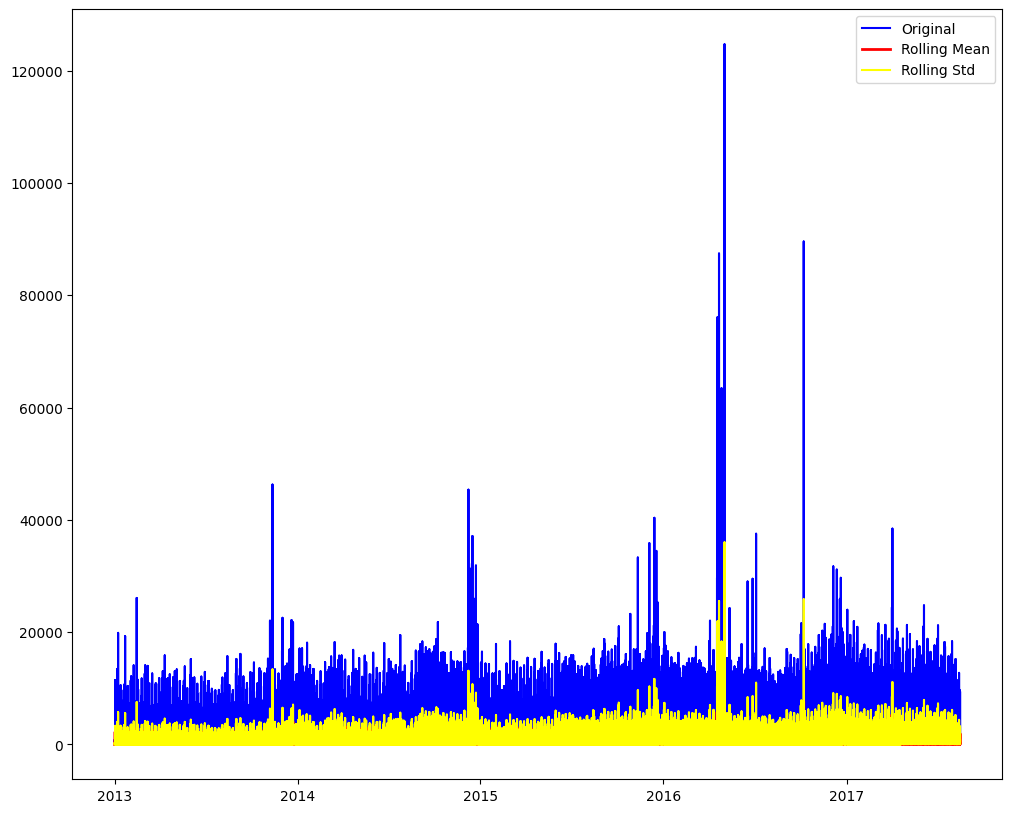

In [ ]:
# Plot the rolling mean and standard deviation to visualize the trend
plt.figure(figsize=(12,10))
plt.plot(df_train_series['sales'], color='blue', label='Original')
plt.plot(rolling_mean, color='red', linewidth=2, label='Rolling Mean')
plt.plot(rolling_std, color='yellow', label='Rolling Std')
plt.legend()
plt.show()

### Testing Stationarity for the year 2013.

We shall subset the dataframe to only include 2013 period.This is to avoid the system taking too long to produce the output.


In [ ]:
# Perform the ADF test on the sales data for 2013 only [TAKES TOO LONG TO RUN]

# result = adfuller(df_train_series.loc[df_train_series['Year'] == 2013, 'sales'])

# result = adfuller(df_train_series['sales'])
# print('ADF Statistic:', result[0])
# print('p-value:', result[1])
# print('Critical Values:', result[4])

### Visualize Seasonality of Sales from 2013 to 2017

Text(0, 0.5, 'Sales')

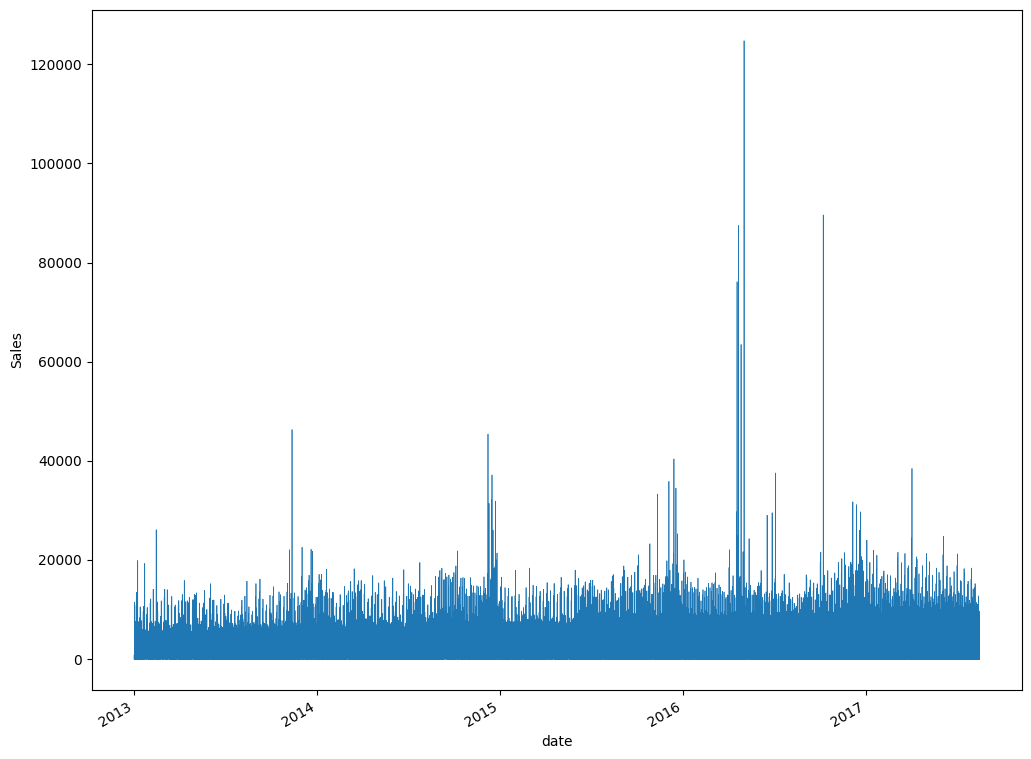

In [ ]:
plt.figure(figsize=(12,10))
ax=df_train_series['sales'].plot(linewidth=0.5)
ax.set_ylabel('Sales')

The code creates a simple line plot of the sales values in the df_train_series DataFrame, with a y-axis label indicating the units of the sales values.
- It's not clear to visualize stationarity, trend, or seasonality from the plot.
- We need therefore to explore the data further

### Seasonality:
To test for seasonality between Year and Sales in df_train dataset, we follow the steps below:
- Convert the 'date' column to a datetime datatype
- Create a new column 'Month' which extracts the month from the 'date' column
- Create a pivot table to calculate the average sales for each year and month
- Create a line plot to visualize the trend of average sales over time

In [ ]:
df_sales_monthly = df_train_series.pivot_table(index=['Year', 'Month'], values='sales', aggfunc='mean')

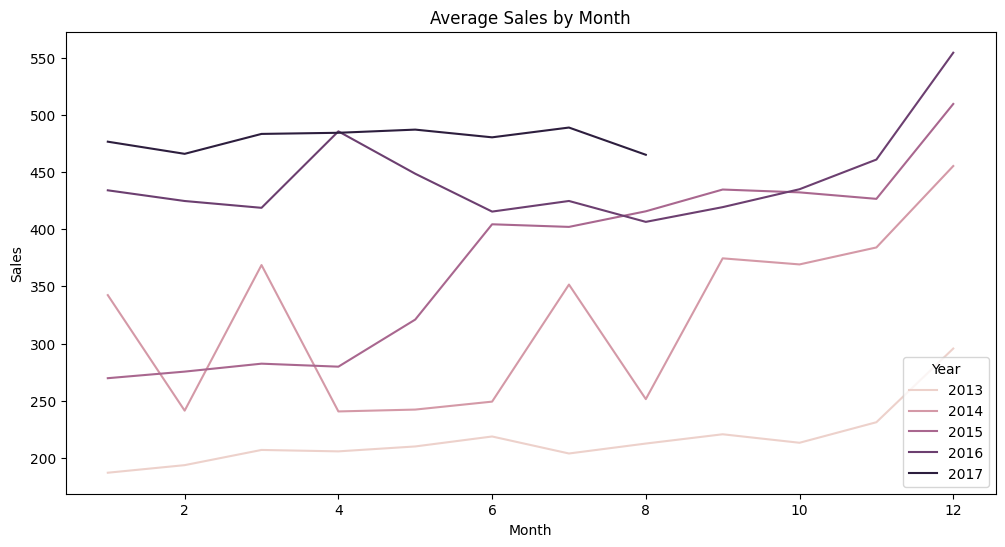

In [ ]:
plt.figure(figsize=(12,6))
sns.lineplot(data=df_sales_monthly, x='Month', y='sales', hue='Year')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

The line plot above shows each year's average sales plotted against each month. We can visually inspect the plot to identify any recurring patterns, such as seasonal spikes or dips in sales.
- From the line graph, we can see that there are seasonal spikes particularly from the month of November towards December.

#### Perform autocorrelation analysis to test for seasonality:
- Create a pivot table to calculate the average sales for each month
- Plot the autocorrelation function (ACF) to visualize the correlation between sales in each month and the sales in the previous months
- The lags parameter will specify the number of time periods to include in the ACF plot. In this case, we set lags=12 to show the correlation between each month's sales and the sales in the previous 12 months.

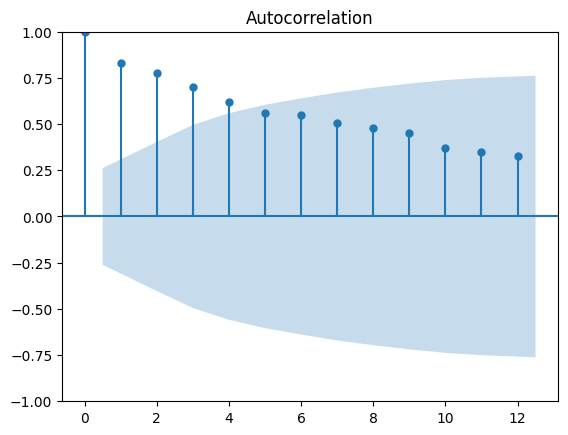

In [ ]:
df_sales_monthly = df_train_series.pivot_table(index=pd.Grouper(freq='M'), values='sales', aggfunc='mean')

# Plot the acf
plot_acf(df_sales_monthly, lags=12)
plt.show()

From the Autocorrelation plot, Month 0 = 1 and Month 12 = 0.3, which suggests that there is a seasonal pattern with the highest seasonal effect occurring at Month 0 (December/January) with a value of 1 and the lowest seasonal effect occurring at Month 12 (December/January) with a value of 0.3.

#### Other Univariate Analysis with df_train Dataset

1. <b><u>Descriptive statistics</u></b>: 
    - We can calculate basic descriptive statistics for the sales column using the describe() method, which gives us information such as the mean, standard deviation, minimum and maximum values, and quartiles as shown below:

In [ ]:
df_train['sales'].describe()

count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

2. <b><u>Distribution plot</u></b>: 
    - We then plot the distribution of the sales column using a histogram or kernel density plot to visualize the shape of the distribution as shown below:

In [ ]:
# sns.histplot(df_train['sales'], kde=True, color='red')

3. <b><u>Box plot</u></b>: 
    - We use a box plot to visualize the distribution of the sales column and identify any outliers.

<AxesSubplot:xlabel='sales'>

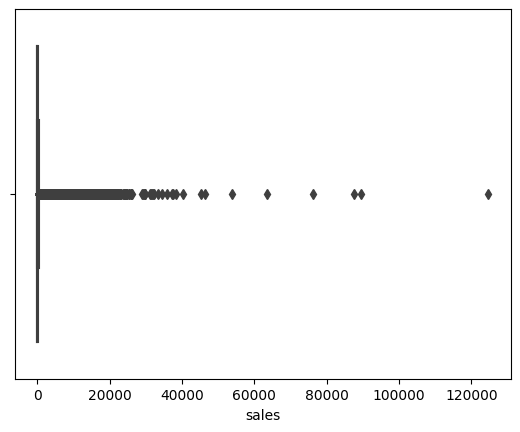

In [ ]:
sns.boxplot(x=df_train['sales'])

4. <b><u>Pivot table</u></b>: 
    - We create a pivot table to summarize the sales column by family and onpromotion categories. 

df_train.pivot_table(values='sales', index='family', columns='onpromotion', aggfunc=np.mean)

### Explore stationarity, trend, and seasonality in df_oil dataset:

In [ ]:
df_oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


To perform seasonality analysis on the df_oil dataframe, we shall follow these steps:
1. Make copy of df_oil dataframe
2. Convert the date column to a datetime object using the pd.to_datetime() function
3. Set the date column as the index of the dataframe using the df.set_index() function
4. Resample the dataframe to a monthly frequency using the df.resample() function
5. Plot the monthly oil prices using a line plot

In [ ]:
df_oil_copy = df_oil.copy()
df_oil_copy['date'] = pd.to_datetime(df_oil_copy['date'])
df_oil_copy.set_index('date', inplace=True)
df_monthly_oil = df_oil_copy.resample('M').mean()

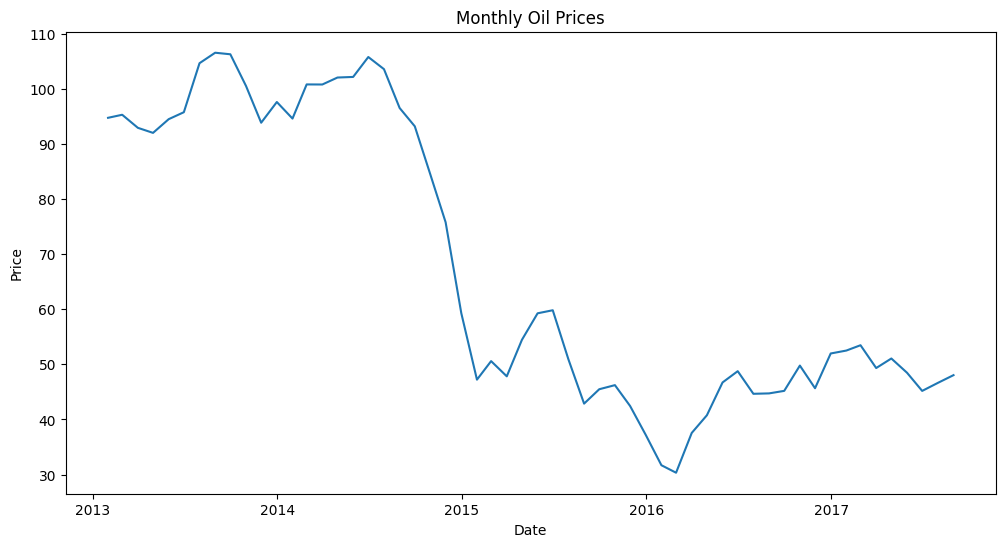

In [ ]:
# Visualize the seasonality

plt.figure(figsize=(12,6))
plt.plot(df_monthly_oil['dcoilwtico'])
plt.title('Monthly Oil Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()


The above plot shows the monthly oil prices as a line plot with the x-axis representing the dates and the y-axis representing the oil prices.

From the plot, we can see that there was a down trend oil oil prices from 2013 to 2016 and an uptrend from 2016 to 2017.

### Decomposing the time series into its seasonal, trend, and residual components using the seasonal_decompose() function from the statsmodels library:
- This will plot the seasonal, trend, and residual components of the time series. And we shall use the plot to identify the presence and strength of seasonality in the data.

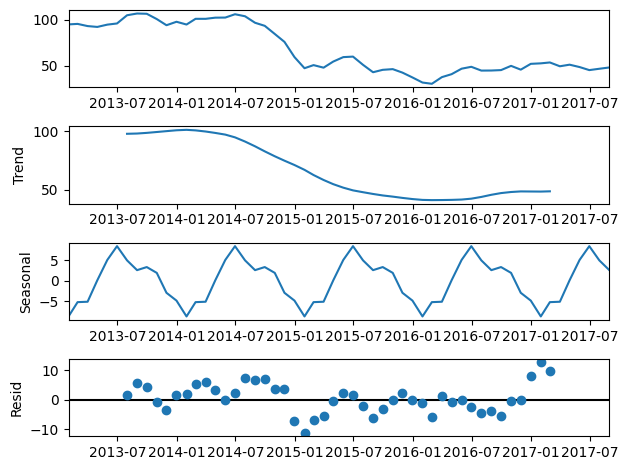

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_monthly_oil, model='additive')
fig = decomposition.plot()
plt.show()

From the above plots:
1. <b>Trend</b>: there is a clear downward trend of oil prices from 2013 to 2016 with a slight upward trend from 2016 to 2017
2. <b>Seasonal</b>: It is clear from the plot that there is a seasonality of oil prices yearly.
3. <b>Resid</b>: The resid component in a seasonal decomposition plot represents the residual variation in the time series that cannot be explained by the seasonal or trend components. It represents the noise or randomness in the data that cannot be attributed to any predictable pattern. In other words, the resid component is the difference between the observed values of the time series and the predicted values based on the seasonal and trend components. 

### Explore stationarity, trend, and seasonality in df_transactions dataset:
To perform seasonality analysis on the df_transactions dataframe, we shall follow these steps:

1. Make copy of df_transactions dataframe
2. Convert the date column to a datetime object using the pd.to_datetime() function
3. Set the date column as the index of the dataframe using the df.set_index() function
4. Resample the dataframe to a monthly frequency using the df.resample() function
5. Plot the monthly oil prices using a line plot

In [ ]:
df_transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [ ]:
df_transactions_copy = df_transactions.copy()
df_transactions_copy['date'] = pd.to_datetime(df_transactions_copy['date'])
df_transactions_copy.set_index('date', inplace=True)
df_monthly_transactions = df_transactions_copy.resample('M').mean()

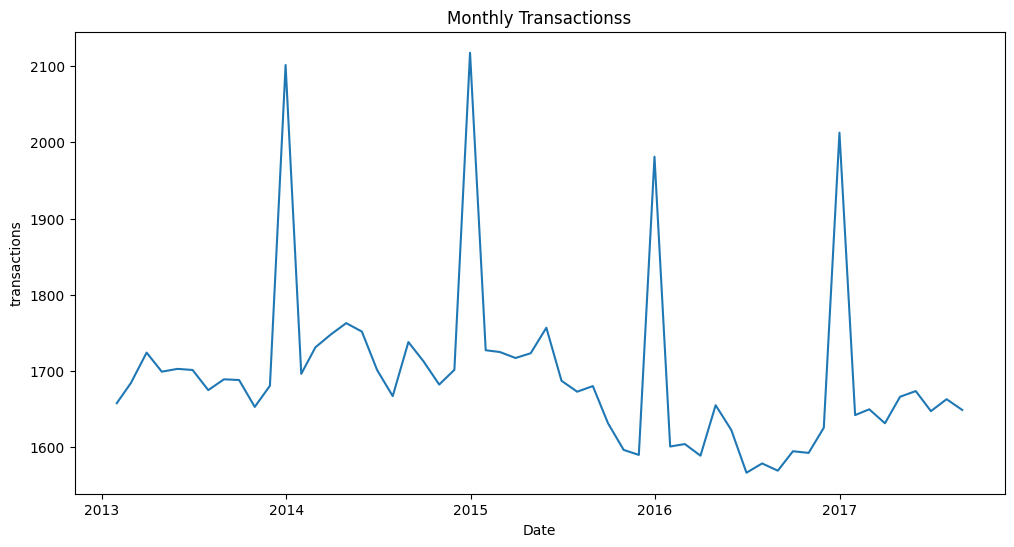

In [ ]:
# Visualize the seasonality

plt.figure(figsize=(12,6))
plt.plot(df_monthly_transactions['transactions'])
plt.title('Monthly Transactionss')
plt.xlabel('Date')
plt.ylabel('transactions')
plt.show()

The plot above shows a clear yearly seasonality of transactions with very high spike of transactions occuring at the end of the year (month of December).

### Decomposing the time series into its seasonal, trend, and residual components using the seasonal_decompose() function from the statsmodels library:
- This will plot the seasonal, trend, and residual components of the time series. And we shall use the plot to identify the presence and strength of seasonality in the data.

In [ ]:
df_transactions_copy.head()

,store_nbr,transactions
date,,
2013-01-01,25,770
2013-01-02,1,2111
2013-01-02,2,2358
2013-01-02,3,3487
2013-01-02,4,1922


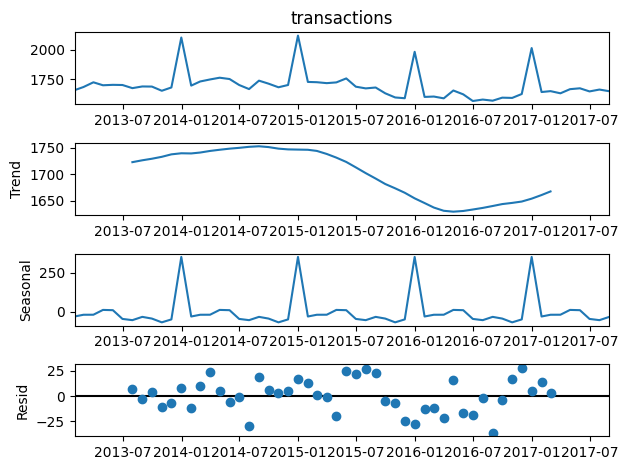

In [ ]:
decomposition_tran = seasonal_decompose(df_monthly_transactions['transactions'], model='additive')
fig = decomposition_tran.plot()
plt.show()

From the above plots:
1. <b>Trend</b>: there is a clear upward trend of transactions from 2013 to 2015 and then a downward trend from end of 2015 to 2016 then again an upward trend from 2016 to 2017.
2. <b>Seasonal</b>: It is clear from the plot that there is a seasonality of transactions happening yearly.
3. <b>Resid</b>: The resid component in a seasonal decomposition plot represents the residual variation in the time series that cannot be explained by the seasonal or trend components. It represents the noise or randomness in the data that cannot be attributed to any predictable pattern. In other words, the resid component is the difference between the observed values of the time series and the predicted values based on the seasonal and trend components. 

### 4.	Bivariate and Multivariate Analysis: 
- This stage involves analysing the relationships between pairs or groups of variables to identify patterns and correlations. 
    1. Bivariate analysis will involve comparing two variables, and
    2. Multivariate analysis will involve analysing the relationships between multiple variables simultaneously.


## Bivariate analysis between sales and onpromotion

In [ ]:
#Check the relationship between Sales and promotion
#calculate pearson corr coefficient
corr_coef=df_train["sales"].corr(df_train["onpromotion"],method="pearson")
print(f"Correlation coefficient between sales and promotion is {corr_coef}")

Correlation coefficient between sales and promotion is 0.4279232048121313


Observation

There seem to be a slightly high positive correaltion between sales and promotion

sales tend to be high when most of the items are on promotion

Text(0.5, 0, 'On Promotion')

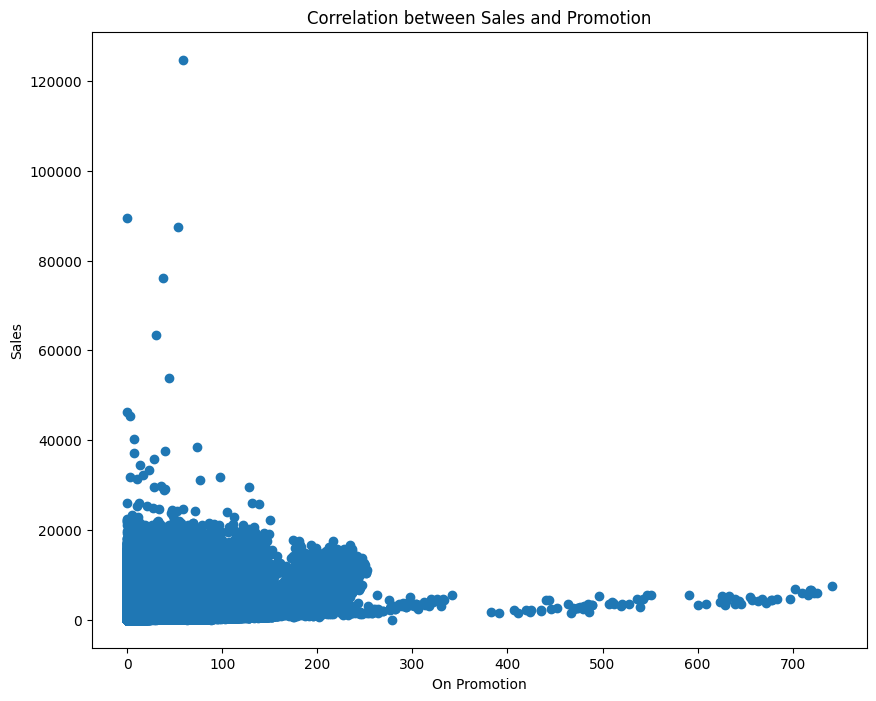

In [ ]:
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(x=df_train["onpromotion"],y=df_train["sales"])
plt.title("Correlation between Sales and Promotion")
plt.ylabel("Sales")
plt.xlabel("On Promotion")

The Graph obviously shows the slightly high correlation between sales and items on promotion
Although high sales were experienced when less items were on promotion 

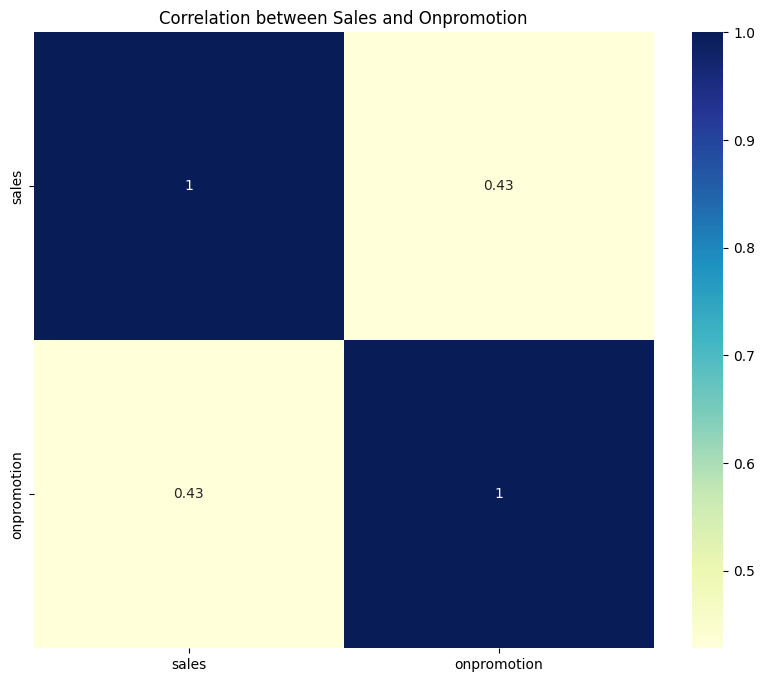

In [ ]:
#matplot
df=pd.DataFrame({"sales":df_train["sales"],"onpromotion":df_train["onpromotion"]})
plt.figure(figsize=(10, 8))
corr_matrix = df.corr()

# Create a heatmap of the correlation in the df_year_amt
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu')

# add a title to the plot
plt.title('Correlation between Sales and Onpromotion')

# Show the plot
plt.show()

## Bivariate analysis between sales and oil prices

In [ ]:
df_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [ ]:
#make a copy of the train df
df_train_copy=df_train
#drop id and reset the index
df_train_copy.drop(columns=["id"]).reset_index(inplace=True)

#convert  date in oil df to a datetime
df_oil["date"]=pd.to_datetime(df_oil["date"])

In [ ]:
df_oil_train=pd.merge(df_train_copy,df_oil,on="date",how="left")

In [ ]:
df_oil_train.head()

,date,id,store_nbr,family,sales,onpromotion,dcoilwtico
0,2013-01-01,0,1,AUTOMOTIVE,0.0,0,NaN
1,2013-01-01,1,1,BABY CARE,0.0,0,NaN
2,2013-01-01,2,1,BEAUTY,0.0,0,NaN
3,2013-01-01,3,1,BEVERAGES,0.0,0,NaN
4,2013-01-01,4,1,BOOKS,0.0,0,NaN


In [ ]:
#Create a DataFrame with oil prices and sales
df_oil_sales=pd.DataFrame({"oil_price":df_oil_train["dcoilwtico"],"sales":df_oil_train["sales"]})

#Calculate correlation coefficient
corr_coef=df_oil_sales["sales"].corr(df_oil_sales["oil_price"],method="pearson")

print(f"Correlation coefficient between sales and oil price is {corr_coef}")

Correlation coefficient between sales and oil price is -0.07905016021992756


There is a very weak correlation between oil prices and sales
the price of oil on the market has no effect on sales

Text(0.5, 0, 'Oil Price')

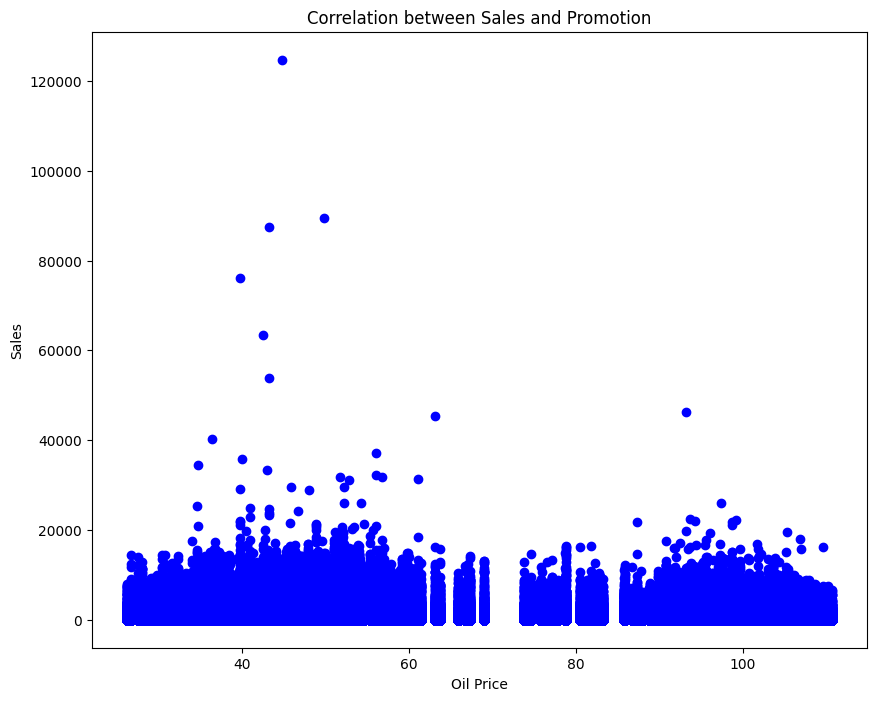

In [ ]:
#scatter plot
plt.figure(figsize=(10,8))
plt.scatter(x=df_oil_sales["oil_price"],y=df_oil_sales["sales"],c="b")
plt.title("Correlation between Sales and Promotion")
plt.ylabel("Sales")
plt.xlabel("Oil Price")

The figure clearly demonstrates the weak correlation between oil and sales

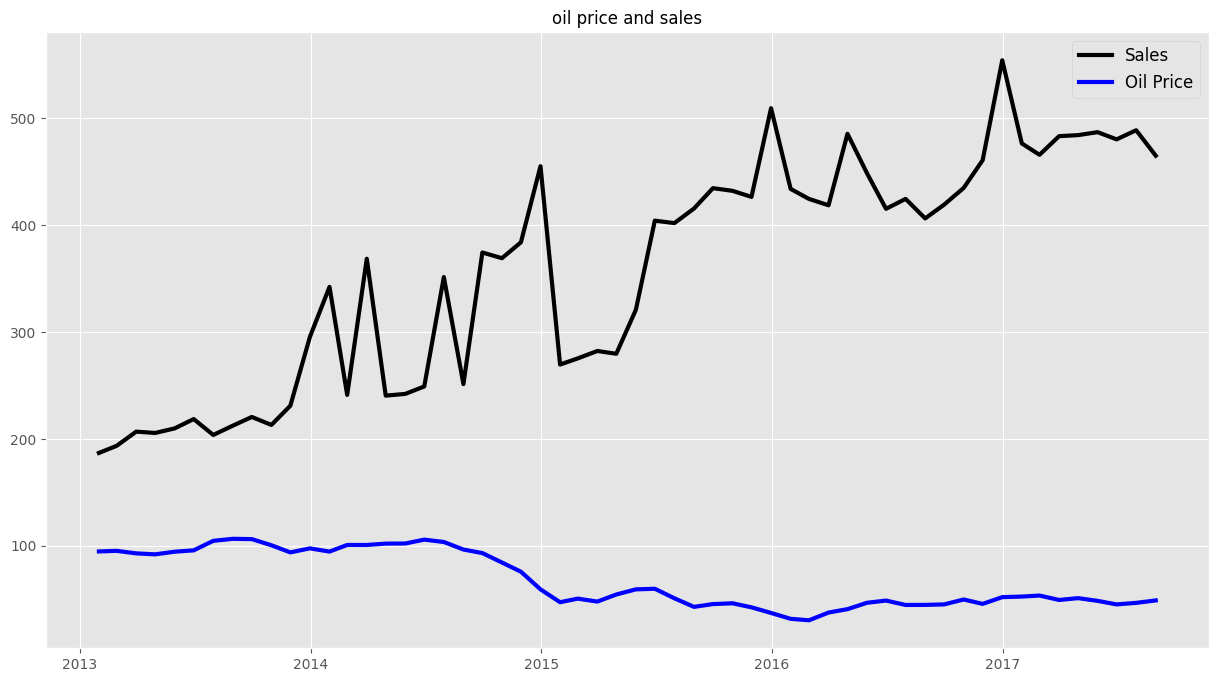

In [ ]:
#Rename the dcoilwtico column to oil price
df_oil_train.rename(columns={"dcoilwtico":"oil price"},inplace=True)

#make a copy
df_oil_train_copy=df_oil_train.copy()
#change date to datetime
df_oil_train_copy["date"]=pd.to_datetime(df_oil_train_copy["date"])

#set date as index
df_oil_train_copy.set_index("date",inplace=True)

#Resample
df_oil_train_copy=df_oil_train_copy.resample("M").mean()
#plot sales and oil price on one graph
plt.figure(figsize=(15,8))
plt.style.use("ggplot")
plt.plot(df_oil_train_copy["sales"],c="k",linewidth=3,label="Sales")
plt.plot(df_oil_train_copy["oil price"],c="b",linewidth=3,label="Oil Price")
plt.title("oil price and sales",fontsize=12)
plt.legend(loc="best",fontsize=12)

### Multivariate Analysis

we will pay attention to how oil price, sales and items on promotion are correlated

the code below finds the correlation coefficients between the three variables
and plots a heatmap of the correlations

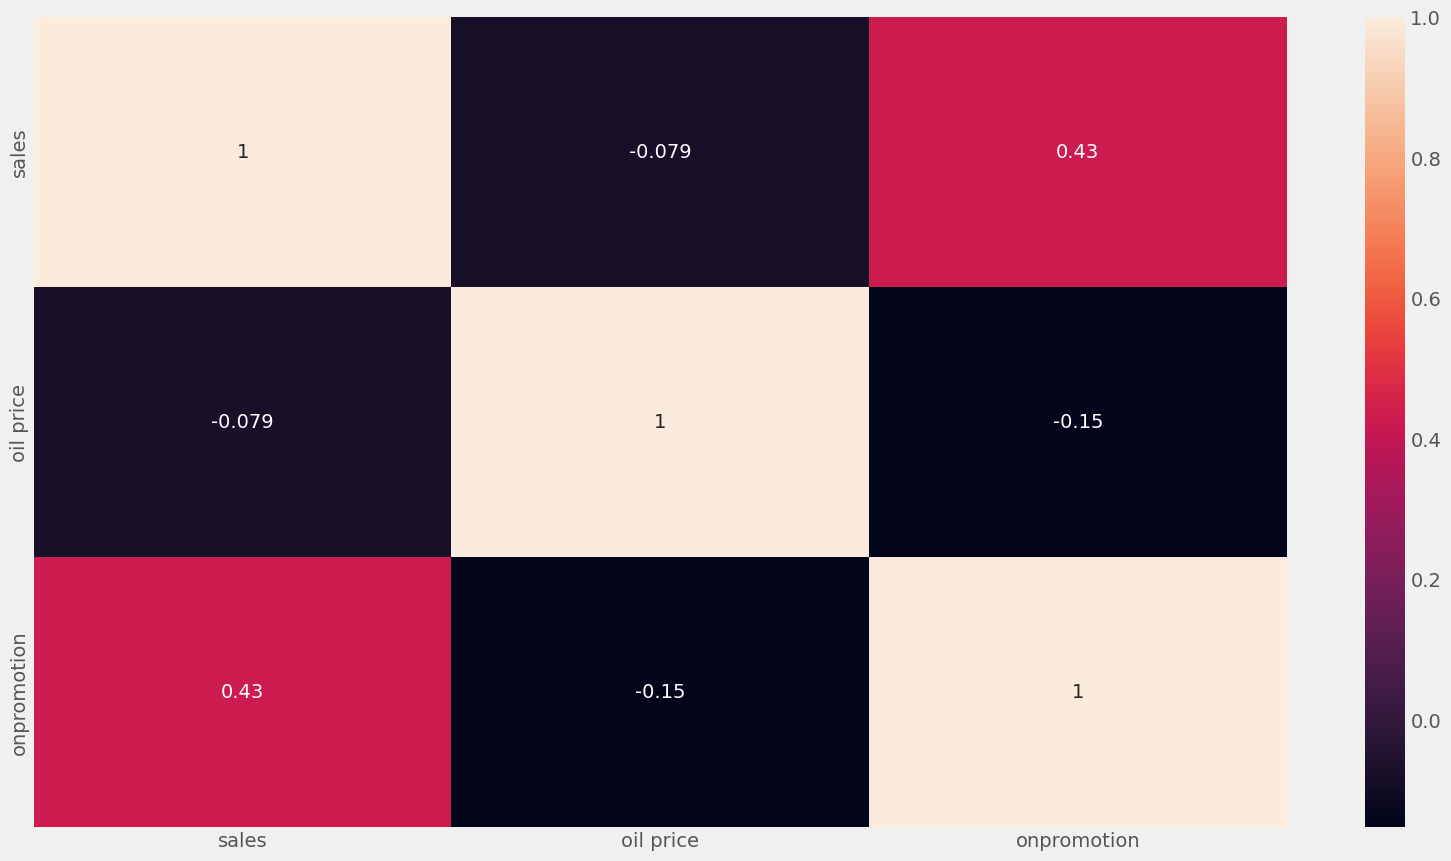

In [ ]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(18,10))
numeric_corr=df_oil_train[["sales","oil price","onpromotion"]].corr()
sns.heatmap(numeric_corr,annot=True);

The heatmap shows the correlation between sales, oil price and items on promotion

Plotting Sales oil price and items on promotion based on the monthly resampling

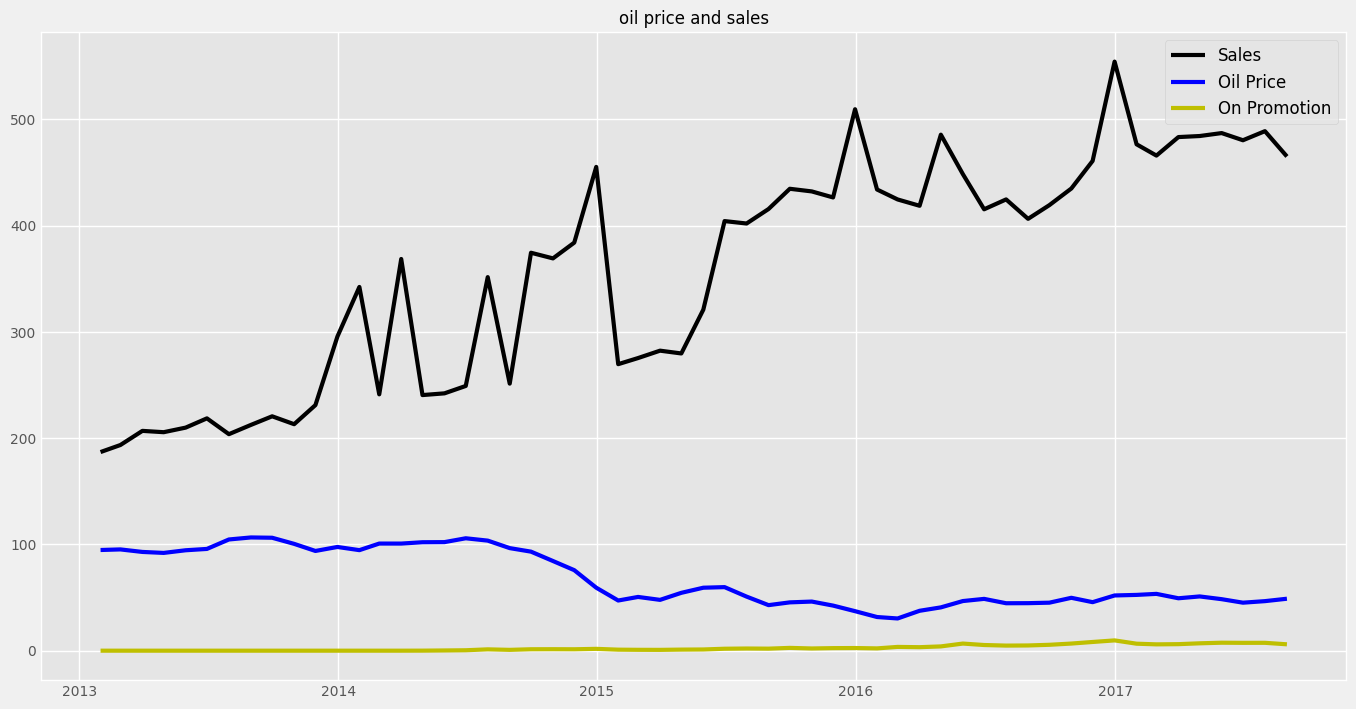

In [ ]:

#plot sales and oil price and on promotion on one graph
plt.figure(figsize=(15,8))
plt.style.use("ggplot")
plt.plot(df_oil_train_copy["sales"],c="k",linewidth=3,label="Sales")
plt.plot(df_oil_train_copy["oil price"],c="b",linewidth=3,label="Oil Price")
plt.plot(df_oil_train_copy["onpromotion"],c="y",linewidth=3,label="On Promotion")
plt.title("oil price and sales",fontsize=12)
plt.legend(loc="best",fontsize=12)

## Observation

Based on the monthly resampling, items on promotion is almost at a zero from 2013 to 2016

However sales tend to incrase every month within this years


### Plotting Sales oil price and items on promotion based on the weekly resampling

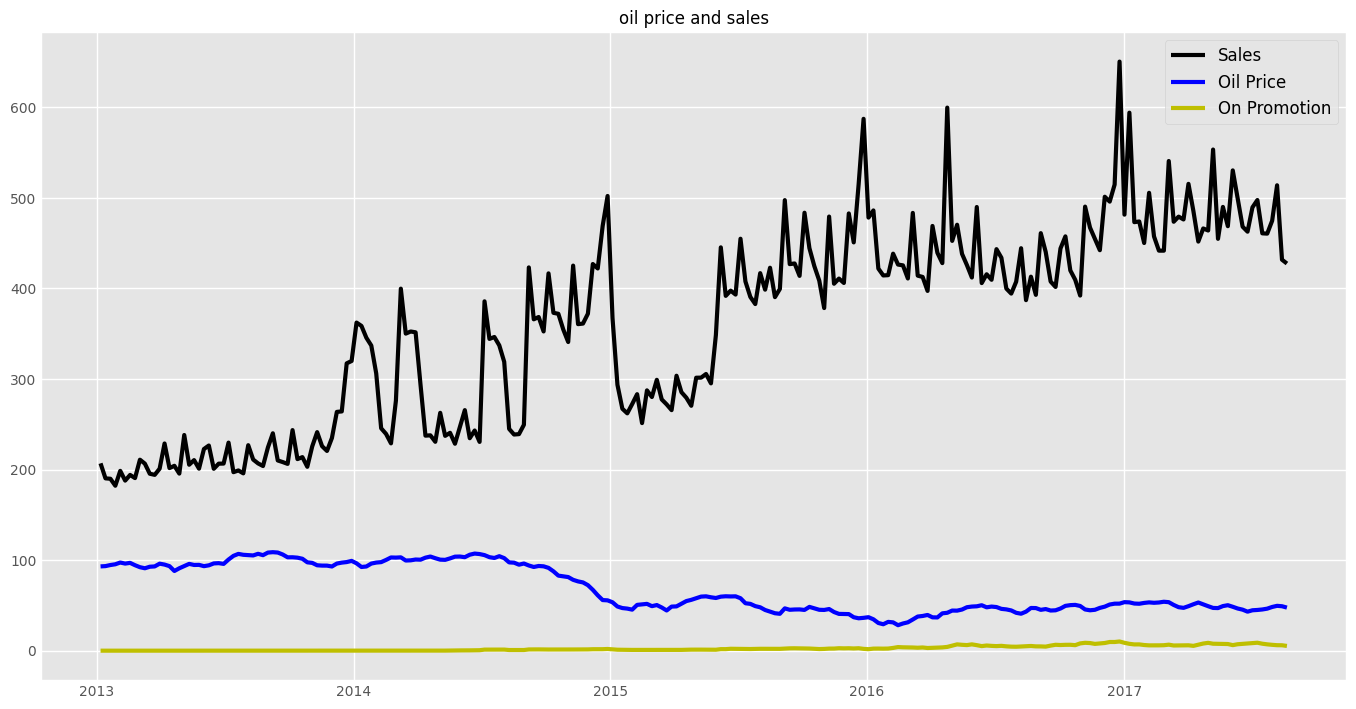

In [ ]:
#make a copy
df_oil_train_copy=df_oil_train.copy()

#change date to datetime
df_oil_train_copy["date"]=pd.to_datetime(df_oil_train_copy["date"])

#set date as index
df_oil_train_copy.set_index("date",inplace=True)
#Resample to weekly
df_oil_train_copy=df_oil_train_copy.resample("W").mean()

#plot sales and oil price and on promotion on one graph
plt.figure(figsize=(15,8))
plt.style.use("ggplot")
plt.plot(df_oil_train_copy["sales"],c="k",linewidth=3,label="Sales")
plt.plot(df_oil_train_copy["oil price"],c="b",linewidth=3,label="Oil Price")
plt.plot(df_oil_train_copy["onpromotion"],c="y",linewidth=3,label="On Promotion")
plt.title("oil price and sales",fontsize=12)
plt.legend(loc="best",fontsize=12)

Although items on promotion has  slightly stronger correlation(0.43) with sales

it effects on sales is very little



### 5.	Hypothesis and Questions:
- The questions below are to be answered. <b>Note</b> that we are free to draw more hypotheses from the data.
    1. Is the train dataset complete (has all the required dates)?
    2. Which dates have the lowest and highest sales for each year?
    3. Did the earthquake impact sales?
    4. Are certain groups of stores selling more products? (Cluster, city, state, type)
    5. Are sales affected by promotions, oil prices and holidays?
    6. What analysis can we get from the date and its extractable features?
    7. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)


### Q1 Is the train dataset complete (has all the required dates)?


In [ ]:
#look at the train data again
df_train.head()

,id,store_nbr,family,sales,onpromotion
date,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0
2013-01-01,1,1,BABY CARE,0.0,0
2013-01-01,2,1,BEAUTY,0.0,0
2013-01-01,3,1,BEVERAGES,0.0,0
2013-01-01,4,1,BOOKS,0.0,0


In [ ]:
#since the date is an index lets reset
df_train.reset_index(inplace=True)

missing_date=pd.date_range(start='2013-01-01', end='2017-08-15').difference(df_train.date.unique())

#now set the date as an index again
df_train.set_index("date",inplace=True)

print(missing_date)

DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


There are missing dates for Christmas days,

There are no sales information on christmas days

### Q2. Which dates have the lowest and highest sales for each year?

1. <b>Add new columns containing the date features to the train data<b>
2. <b>Plot sales over year, months and days<b>

In [ ]:
#Create new columns
df_train_copy["year"]=df_train_copy.index.year
df_train_copy["month"]=df_train_copy.index.month
df_train_copy["weekday"]=df_train_copy.index.day_of_week

In [ ]:
df_train_copy.head()

,id,store_nbr,family,sales,onpromotion,year,month,weekday
date,,,,,,,,
2013-01-01,0,1,AUTOMOTIVE,0.0,0,2013,1,1
2013-01-01,1,1,BABY CARE,0.0,0,2013,1,1
2013-01-01,2,1,BEAUTY,0.0,0,2013,1,1
2013-01-01,3,1,BEVERAGES,0.0,0,2013,1,1
2013-01-01,4,1,BOOKS,0.0,0,2013,1,1


Which months have the highest sales of each year

Text(0.5, 1.0, 'Sales per month')

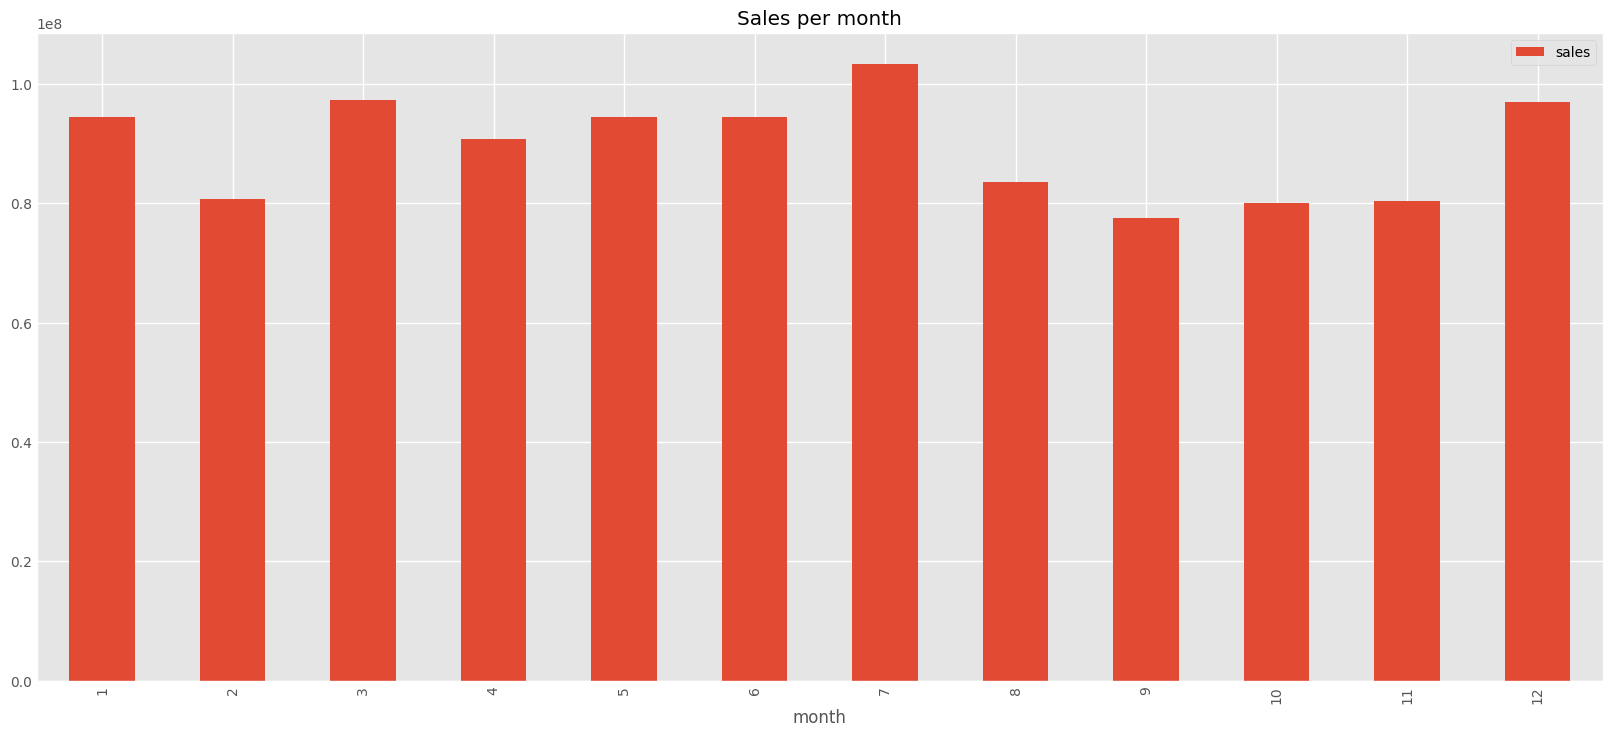

In [ ]:
#Create a df and groupby month, agg sales using the sum 
month_grp=df_train_copy.groupby("month",as_index=False)["sales"].sum()

#plot sales for each month
month_grp.plot(kind="bar",x="month",y="sales",figsize=(18,8))
plt.title("Sales per month")

Sales tend to be higher in the beginning, middle and end of the year

### which Days have the highest and lowest sales

Text(0.5, 1.0, 'Sales per weekday')

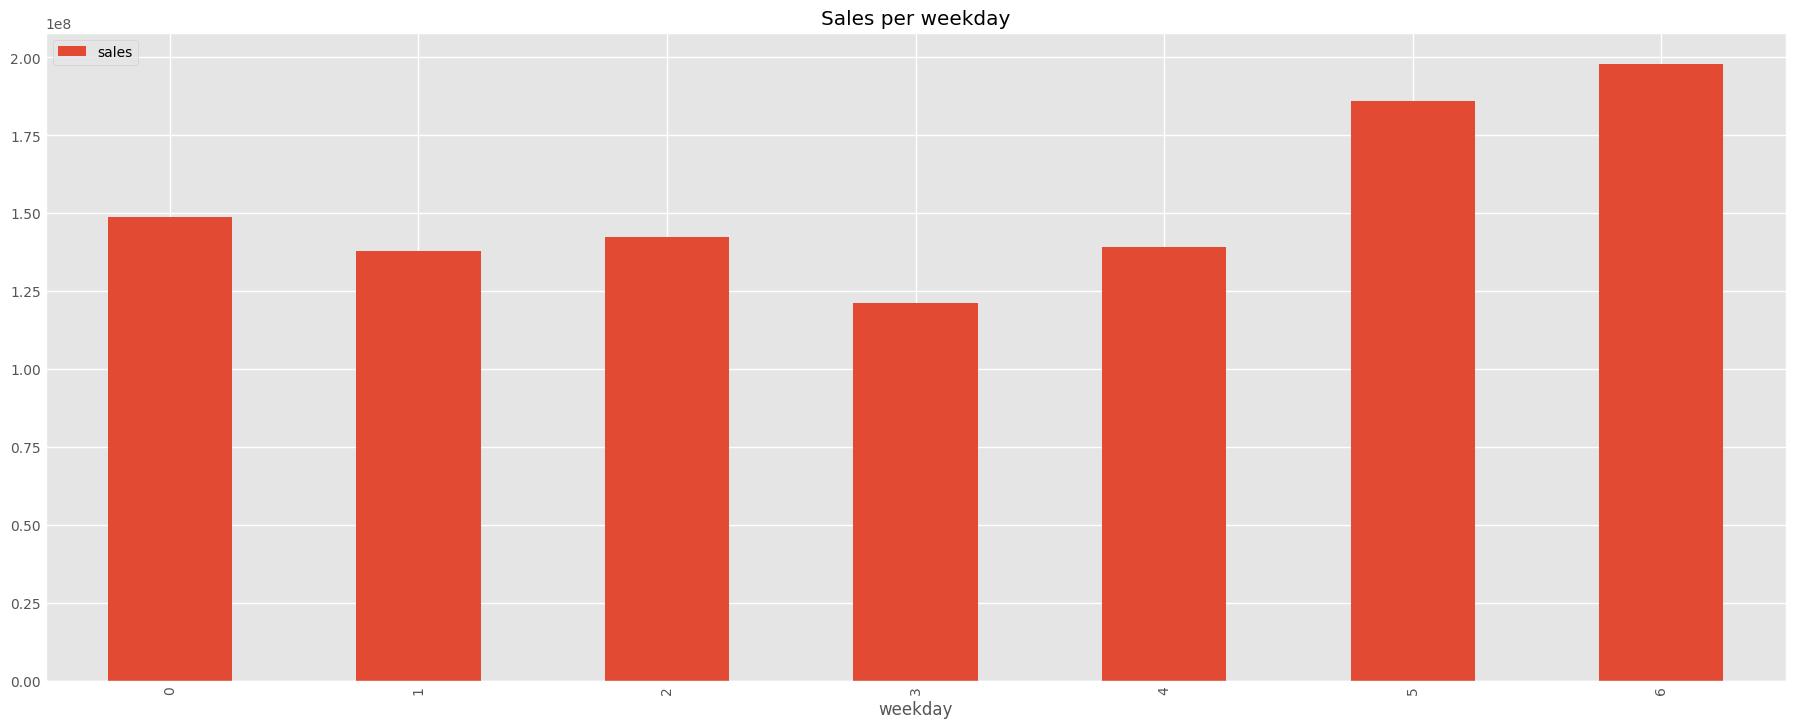

In [ ]:
#Create a df and groupby weekday, agg sales using the sum 
day_grp=df_train_copy.groupby("weekday",as_index=False)["sales"].sum()

#plot sales for each day
day_grp.plot(kind="bar",x="weekday",y="sales",figsize=(20,8))
plt.title("Sales per weekday")

Sales tend to be highe on Weekends, saturdays and sundays
and lower i n the middle of the week

We can verify by checking if there are no outliers for sales on these days

### Q3 Did the earthquake impact sales?

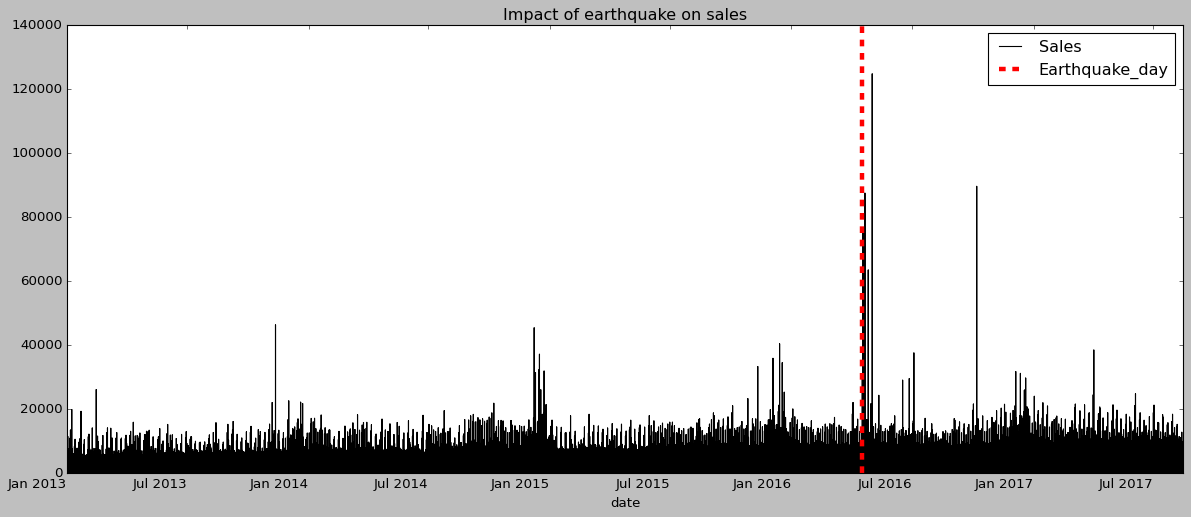

In [ ]:
#Day of earthquake
Earthquake_day=pd.to_datetime('2016-04-16')

#plot sales and earthquake
#set style
plt.style.use("classic")
#plot graph
fig_ax=df_train["sales"].plot(kind="line",figsize=(18,8),color="black",label="Sales",);
#add vertical line
fig_ax.axvline(Earthquake_day,ls="--",color="red",label="Earthquake_day", linewidth=4);
#set title and legend
plt.title("Impact of earthquake on sales")
plt.legend(loc="best")

plt.xticks(rotation=0);


<b>There is a significant increase in sales right after the earthquake<b>

<b>This means the earthquake had a huge impact on sales causing sales to rise<b>

## Q4 Are certain groups of stores selling more products? (Cluster, city, state, type)

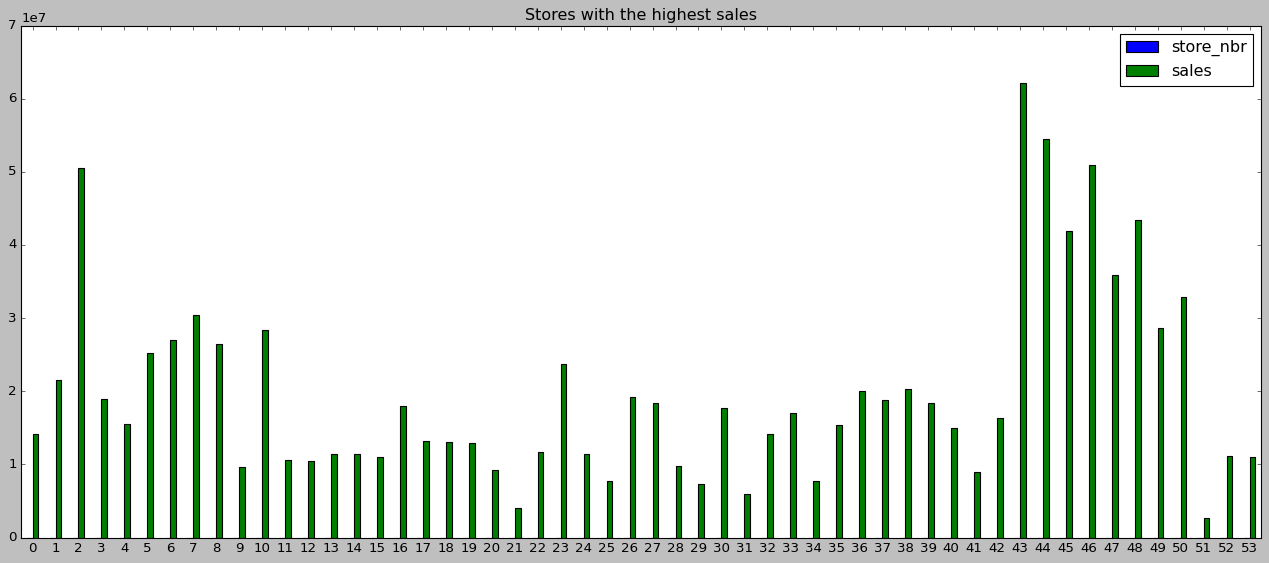

In [ ]:
store_grp=df_train.groupby("store_nbr",as_index=False)["sales"].sum()

store_grp.plot(kind="bar",figsize=(20,8),title="Stores with the highest sales");
plt.xticks(rotation=0);

<b>Stores 2, 44, 45 and 46 have the highest sales<b>

# Highest sales by city

In [ ]:

#make a copy of train df and reset index
df=df_train.copy().reset_index()
#merge store and train datasets on store_nbr
store_train_df=pd.merge(df_train,df_stores,on="store_nbr")
#group by city
city_grp=store_train_df.groupby("city", as_index=False)["sales"].sum()
#Print top 5 cities
city_grp.sort_values(by="sales",ascending=False,inplace=True)

city_grp.head()

,city,sales
18,Quito,5.567418e+08
8,Guayaquil,1.229673e+08
3,Cuenca,4.916860e+07
0,Ambato,4.030440e+07
21,Santo Domingo,3.583432e+07


In [ ]:
#set style
plt.style.use("fivethirtyeight")
#plot top 10 cities
data=city_grp.head(10)

data.plot("city","sales",kind="barh",title="Top 10 cities with most sales",figsize=(12,8))

The highest sales occurs in Quito, lets check how the stores are distributed in the country

In [ ]:
#How are the stores distributed around the country

stores_dist=df_stores.groupby(['city']).count().sort_values(by="store_nbr",ascending=False)
stores_dist.head()

Quito observed the highest sales because thats where most of the stores are located

In [ ]:
plt.style.use("fivethirtyeight")
stores_dist["store_nbr"].plot(kind="barh",figsize=(12,8),);
plt.title("Store Distribution")
plt.ylabel("Number of Stores")

Store distribution follows the same trend as sales the higher the number of stores in the city the higher the sales in that city we can further go down to check which stores are generating the most sales in the cities with 2 or more stores

Q5. Are sales affected by promotions, oil prices and holidays?

### Sales and Promotions

In [ ]:
#make a copy
df_oil_train_copy=df_oil_train.copy()

#change date to datetime
df_oil_train_copy["date"]=pd.to_datetime(df_oil_train_copy["date"])

#set date as index
df_oil_train_copy.set_index("date",inplace=True)
#Resample to weekly
df_oil_train_copy=df_oil_train_copy.resample("W").mean()

#plot sales and oil price and on promotion on one graph
plt.figure(figsize=(15,8))
plt.style.use("classic")
plt.plot(df_oil_train_copy["sales"],linewidth=3,label="Sales")
plt.plot(df_oil_train_copy["oil price"],linewidth=3,label="Oil Price")
plt.plot(df_oil_train_copy["onpromotion"],linewidth=3,label="On Promotion")
plt.title("oil price and sales",fontsize=12)
plt.legend(loc="best",fontsize=12)

In [ ]:
#Create subplots
fig,axs=plt.subplots(1,3,sharex=True,sharey=False,figsize=(24,8))


fig.suptitle("Comparing the Effect of oil price and promotion on sales")

ax=ax.ravel()

#plot individual graphs
axs[0].plot(df_oil_train_copy["sales"],linewidth=3,label="Sales",c="m")
axs[0].legend()
axs[1].plot(df_oil_train_copy["oil price"],linewidth=3,label="Oil Price",c="r")
axs[1].legend()
axs[2].plot(df_oil_train_copy["onpromotion"],linewidth=3,label="On Promotion",c="y")
axs[2].legend()

In [ ]:
ax